# Importing and processing neuron data (numpy files) for modeling:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Originally Written: 04.07.25 

Last updated: 09.29.25


This code will walk you through the process in which raw neuron trace files (processed with 'Extracting Data from tif Files (videos).ipynb') are normalized for modeling. Normalized traces have already been saved in the provided numpy files on GitHub, so this is more for informational purposes. It is not necessary to run this notebook to run the other modeling notebooks.

Walkthrough will only be demonstrated for WT AIB data across a full set of experiments (odor, red light, odor+red light) for simplicity, but the same process is applied to all data.

* *NOTE*: nmr-1::HisCl (motor-silenced) worms contain data for AVA, but the activity is very low. For this reason, we don't use this data because the normalization process amplifies the low activity into noise. We simply omit it during modeling. Recordings are just for confirmation of silencing. 
* This applies to the str-2::HisCl (AWC-silenced) worms for AWC activity, and ins-1s::HisCl (AIA-silenced) worms for AIA activity.


* *NOTE*: Data for str-2::HisCl (AWC-silenced) experiments were performed using just red-light stimulation, as this was performed much later after initial experiments with other (nmr-1::HisCl and ins-1s::Hiscl) silencing experiments, and we realized it was not necessary to perform all 3 phases when only 1 phase is necessary for modeling. Normalization for this is detailed below in block 8, since normalization across a full set of experiments was not performed. 

** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [1]:
## Imports ##

import numpy as np
import matplotlib.pyplot as plt

In [60]:
## Importing Dictionary Datasets ##

# Datasets are already provided. 
# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

# AVA-AIB-AIA traces for str-2::HisCl (AWC-silenced) worms - 14 worms #
strHis_dict = np.load('str-2_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(strHis_dict)

# AVA-AIB-AIA traces for ins-1s::HisCl (AIA-silenced) worms - 12 worms #
insHis_dict = np.load('ins-1s_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(insHis_dict)

print("Imported data successfully!")

Imported data successfully!


In [61]:
# Find and return data arrays of interest for each worm, type of trace (raw, background-corrected, or normalized), 
# and experiment (odor, red light, odor+red [named "both"]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out full set of experiments for each neuron (AIB only shown here)
# To pull out other neuron data, replace any instance of AIB with other names (AVA, AIA)
# We will use background subtracted data, which are just the raw traces minus background (BG) in dictionaries

WT_AIB_bgcorr_odor = FindNeurons(WT_dict, "BG Corr", "AIB", "Odor")
#print(WT_AIB_bgcorr_odor)

WT_AIB_bgcorr_red = FindNeurons(WT_dict, "BG Corr", "AIB", "Red")
#print(WT_AIB_bgcorr_red)

WT_AIB_bgcorr_both = FindNeurons(WT_dict, "BG Corr", "AIB", "Both")
#print(WT_AIB_bgcorr_both)

print("Neurons found")
#print data above to test

Neurons found


In [20]:
## - Smoothing Traces - ##

# Smoothing helps to reduce jitter/noise in traces, so that it doesn't interfere with modeling
# Process involves shifting each trace by a certain number of frames (5 seems to be sufficient without 
# over-smoothing), where trace is shifted in the beginning and end by the same number of frames, then 
# averaged with original trace to produce new, smoothed trace. Frame rate is 10fps.

def Smooth(array, shift): # we shift by 5 frames, too much will over-smooth and too little will not reduce noise

    smoothed = [] 
    step = (2*shift) + 1 #total number of arrays from shifting, plus original array
    
    for a in array:
        temp = []

        for i in range(shift): #shift array one at a time
            plus = a[(i+1):]
            plus = np.append(plus, [np.nan]*(i+1)) #add nans at beginning

            minus = a[:-(i+1)]
            minus = np.insert(minus, 0, [np.nan]*(i+1)) #add nans at end

            temp.append(plus) #append beginning-shifted array
            temp.append(minus) #append end-shifted array

        temp.append(a) #append original array

        smooth = np.sum(temp, axis = 0) / step #average all arrays 
        smoothed.append(smooth[shift:-shift]) #cuts off nans in beginning and end generated from shifting
    
    return smoothed


# WT data #
WT_AIB_odor_smooth = Smooth(WT_AIB_bgcorr_odor, 5)
WT_AIB_red_smooth = Smooth(WT_AIB_bgcorr_red, 5)
WT_AIB_both_smooth = Smooth(WT_AIB_bgcorr_both, 5)

print("Traces smoothed")
#print data above to test

Traces smoothed


Text(0.5, 0, 'Time (frames)')

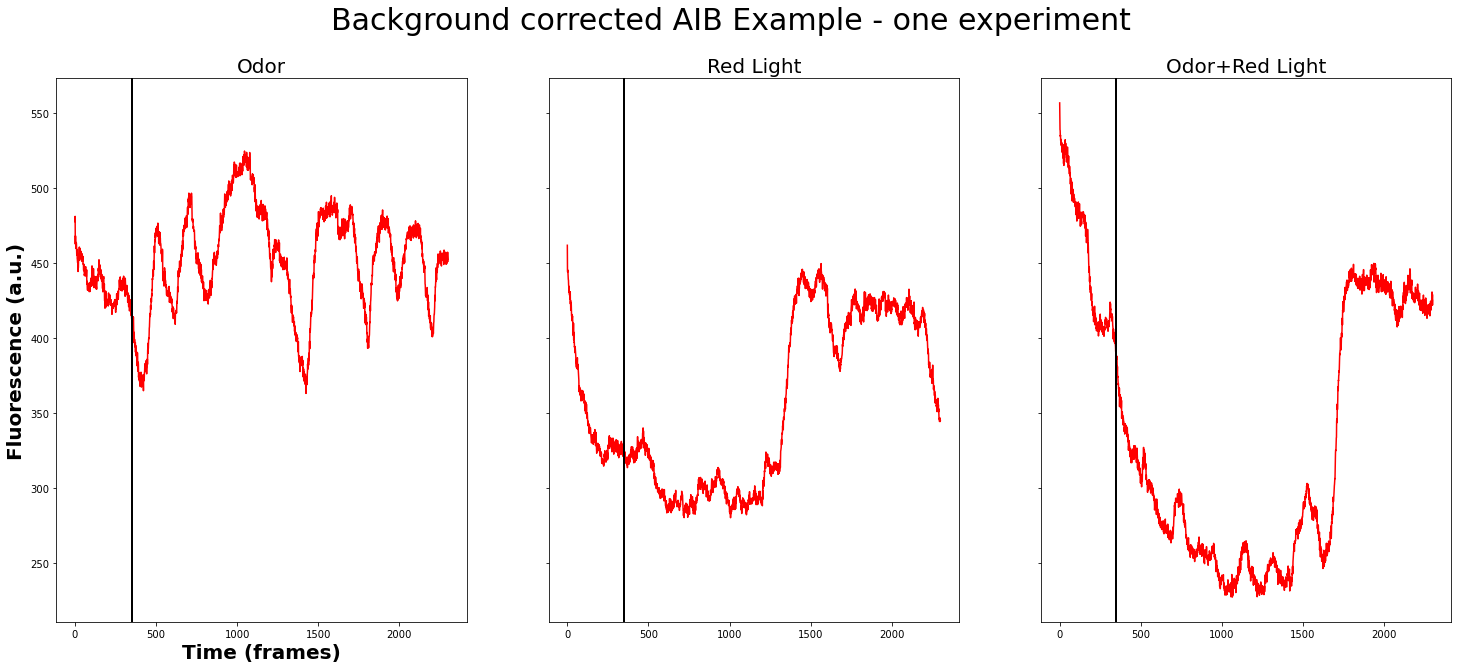

In [21]:
# There are 300 frames (30 seconds, 10 frames per second) of no stimulus in the beginning of each trace 
# There is also a photodecay artifact, so we cut off an additional 50 frames for a total of 350 frames/35 seconds.
# We do this for normalization because the beginning high activity sets an artifical Fmax that is not present
# in rest of traces. Black line below shows cutoff.

fig, ax = plt.subplots(1,3, figsize=(25,10), sharex='all', sharey='all')
plt.suptitle('Background corrected AIB Example - one experiment', fontsize=30)
ax[0].set_title('Odor', fontsize=20)
ax[0].plot(WT_AIB_bgcorr_odor[0], color='red')
ax[1].set_title('Red Light', fontsize=20)
ax[1].plot(WT_AIB_bgcorr_red[0], color='red')
ax[2].set_title('Odor+Red Light', fontsize=20)
ax[2].plot(WT_AIB_bgcorr_both[0], color='red')
ax[0].axvline(x=350, linewidth=2, color='black')
ax[1].axvline(x=350, linewidth=2, color='black')
ax[2].axvline(x=350, linewidth=2, color='black')
ax[0].set_ylabel('Fluorescence (a.u.)', fontsize=20, weight='bold')
ax[0].set_xlabel('Time (frames)', fontsize=20, weight='bold')

In [70]:
## - Normalize data for every worm across a full set of experiments - ##

# Normalization of traces from 0-1 helps standardize them for modeling, especially since different neuron
# promoters and individual worms have varying fluorescence intensities. 
# We normalize worms across a full set of 3 experiments (odor, red light, odor+red light), to fully capture each
# neuron's dynamic range. Because some experiments are designed to not activate certain neurons, if we normalized
# each individual trace, it would appear as noise due to inactivity. 
# We use smoothed traces (above) for normalization, again to reduce noise. 
# Normalization formula: (F - Fmin) / (Fmax - Fmin) where Fmin/max is the min/max from one set of experiments.

def Normalize_exps(odor, red, both, cutoff, worms, exps): 
#need to reshape normalize arrays by number of worms and experiments (3)

    norms = []
    
    for i in range(worms):
        one_exp = np.concatenate((odor[i][cutoff:], red[i][cutoff:], both[i][cutoff:]))
        # We will cut off the first 350 frames, and then will combine the traces so that the 3 experiments are 
        # combined for each worm. 
        mins = np.min(one_exp) # find min across all 3 exps per worm
        maxs = np.max(one_exp) # find max across all 3 exps per worm
        
        for f in one_exp:
            norm = (f - mins)/(maxs - mins) # apply normalization formula
            norms.append(norm)
        
    norms = np.reshape(norms,(worms*exps,len(odor[0][cutoff:]))) # reshape so that can be separated back into exps

    norm_odor = [] # separate normalized traces back into respective exps
    norm_red = [] 
    norm_both = [] 

    for count in range(worms):
        norm_odor.append(norms[count*3]) # apply count so that odor exps correspond to indices 0, 3, 6, etc
        norm_red.append(norms[count*3 + 1]) # same as above for indices 1, 4, 7, etc
        norm_both.append(norms[count*3 + 2]) # same for indices 2, 5, 8, etc
    
    return norm_odor, norm_red, norm_both


# WT data #
WT_worm_num = 15

WT_AIB_norm = Normalize_exps(WT_AIB_odor_smooth, WT_AIB_red_smooth, WT_AIB_both_smooth, 350, WT_worm_num, 3)

WT_AIB_norm_odor = WT_AIB_norm[0]
WT_AIB_norm_red = WT_AIB_norm[1]
WT_AIB_norm_both = WT_AIB_norm[2]

# Worm numbers for other datasets:
# WT_AWC_worm_num = 20
# rimHis_worm_num = 20
# insHis_worm_num = 12
# strHis_worm_num = 14

print("Traces normalized")
#print data above to test

Traces normalized


(0.0, 1.0)

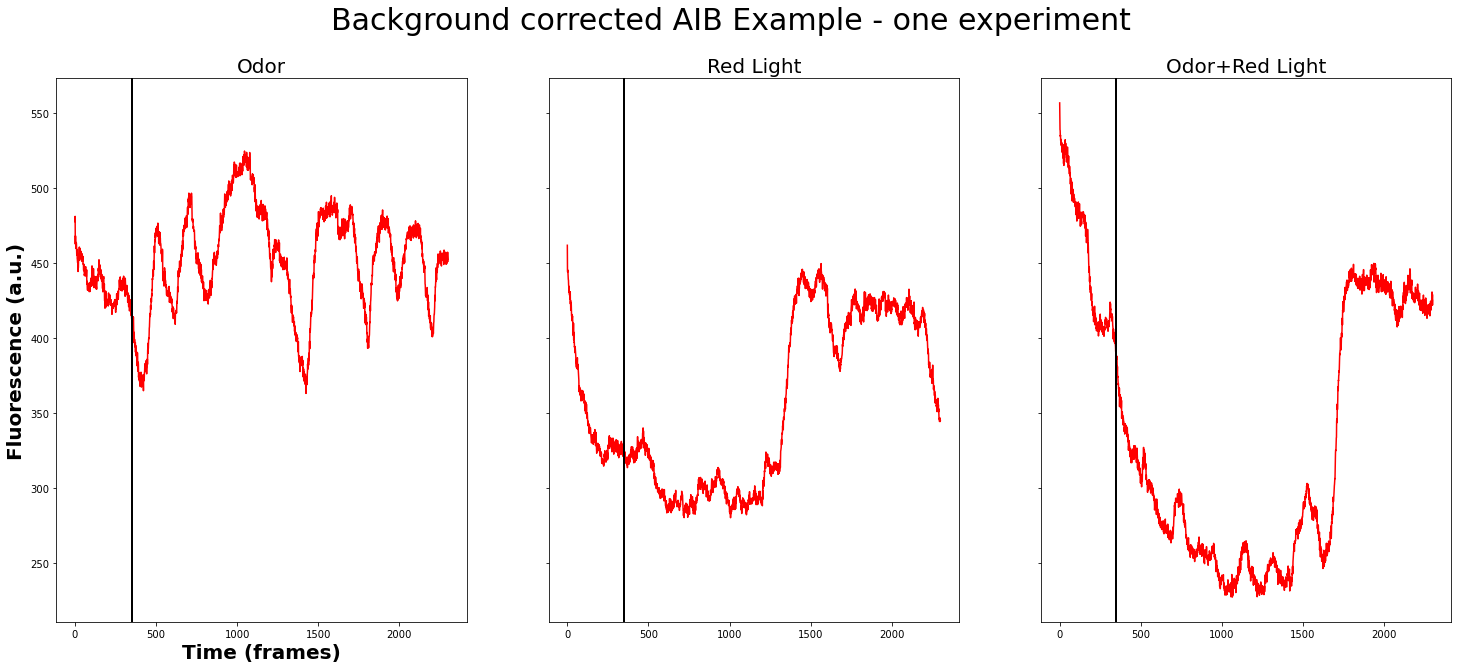

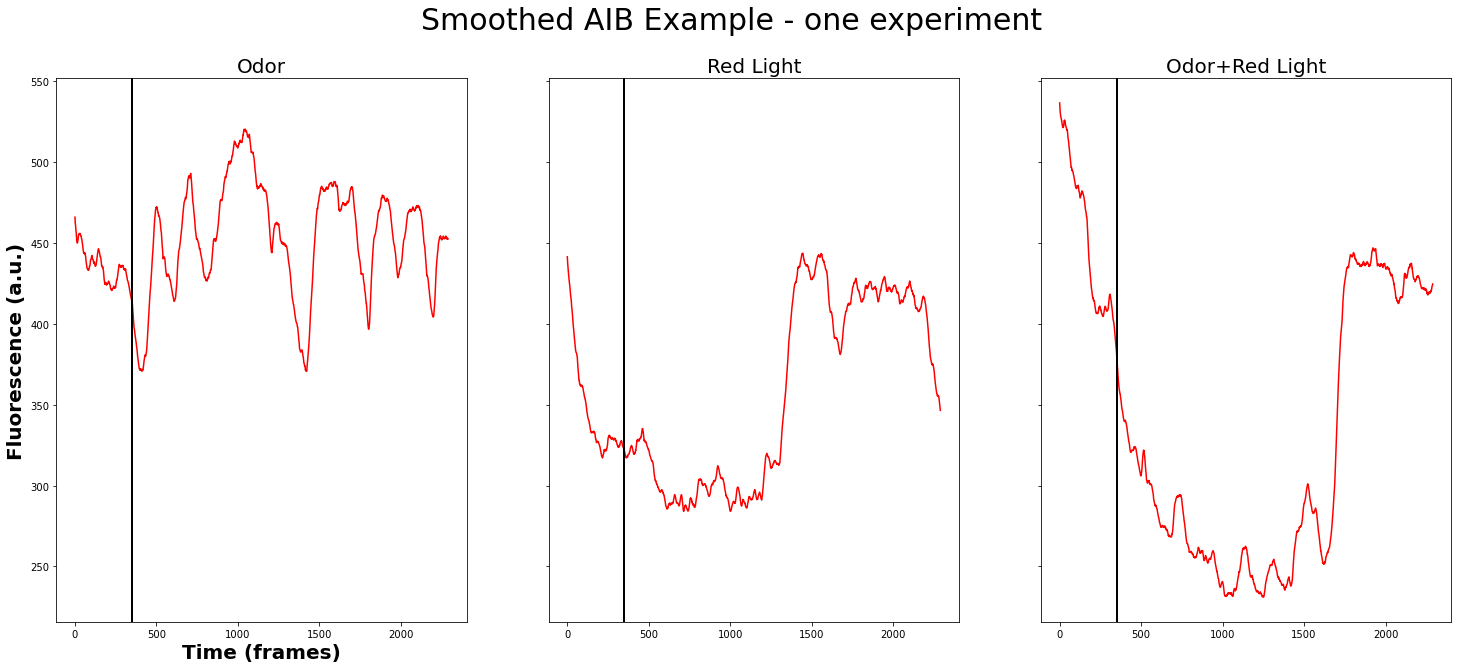

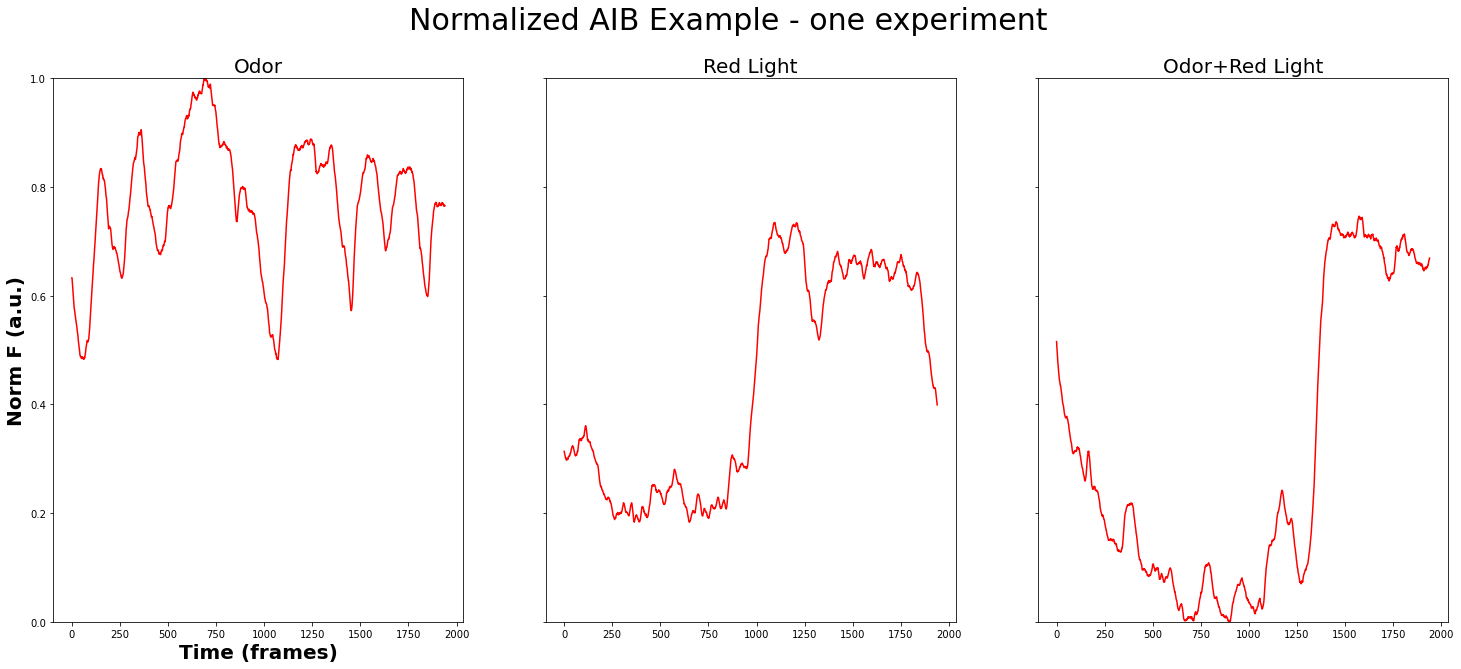

In [48]:
## Example of AIB background corrected data before and after smoothing, and after normalization, cutoff in black ##

fig, ax = plt.subplots(1,3, figsize=(25,10), sharex='all', sharey='all')
plt.suptitle('Background corrected AIB Example - one experiment', fontsize=30)
ax[0].set_title('Odor', fontsize=20)
ax[0].plot(WT_AIB_bgcorr_odor[0], color='red')
ax[1].set_title('Red Light', fontsize=20)
ax[1].plot(WT_AIB_bgcorr_red[0], color='red')
ax[2].set_title('Odor+Red Light', fontsize=20)
ax[2].plot(WT_AIB_bgcorr_both[0], color='red')
ax[0].axvline(x=350, linewidth=2, color='black')
ax[1].axvline(x=350, linewidth=2, color='black')
ax[2].axvline(x=350, linewidth=2, color='black')
ax[0].set_ylabel('Fluorescence (a.u.)', fontsize=20, weight='bold')
ax[0].set_xlabel('Time (frames)', fontsize=20, weight='bold')

fig, ax = plt.subplots(1,3, figsize=(25,10), sharex='all', sharey='all')
plt.suptitle('Smoothed AIB Example - one experiment', fontsize=30)
ax[0].set_title('Odor', fontsize=20)
ax[0].plot(WT_AIB_odor_smooth[0], color='red')
ax[1].set_title('Red Light', fontsize=20)
ax[1].plot(WT_AIB_red_smooth[0], color='red')
ax[2].set_title('Odor+Red Light', fontsize=20)
ax[2].plot(WT_AIB_both_smooth[0], color='red')
ax[0].axvline(x=350, linewidth=2, color='black')
ax[1].axvline(x=350, linewidth=2, color='black')
ax[2].axvline(x=350, linewidth=2, color='black')
ax[0].set_ylabel('Fluorescence (a.u.)', fontsize=20, weight='bold')
ax[0].set_xlabel('Time (frames)', fontsize=20, weight='bold')

# Note change in scale of y-axis
fig, ax = plt.subplots(1,3, figsize=(25,10), sharex='all', sharey='all')
plt.suptitle('Normalized AIB Example - one experiment', fontsize=30)
ax[0].set_title('Odor', fontsize=20)
ax[0].plot(WT_AIB_norm_odor[0], color='red')
ax[1].set_title('Red Light', fontsize=20)
ax[1].plot(WT_AIB_norm_red[0], color='red')
ax[2].set_title('Odor+Red Light', fontsize=20)
ax[2].plot(WT_AIB_norm_both[0], color='red')
ax[0].set_ylabel('Norm F (a.u.)', fontsize=20, weight='bold')
ax[0].set_xlabel('Time (frames)', fontsize=20, weight='bold')
ax[0].set_ylim([0,1])

In [71]:
## - Normalize individual videos - For str-2::HisCl (AWC-silenced) worms - ##

# NOTE: Since str-2::HisCl (AWC-silenced) worms only have one set of recordings per worm for just the 
# red light experiments, we cannot normalize them across a full set of experiments. 
# Instead, we just normalize each trace with itself. It should be noted that while performing these 
# experiments, we ensured each neuron in each video had a full range of activity. Therefore, normalization of 
# these invdividual traces is comparable to normalizing across 3 experimental phases for the other silenced
# (nmr-1::HisCl and ins-1s::HisCl) experiments. 

def Norm1(array, cutoff, worms): # Normalization performed for each individual trace #

    norms1 = []
    
    for a in array:
        new_a = a[cutoff:] # cutoff first 350 frames
        mins = np.min(new_a) # find min of individual truncated trace
        maxs = np.max(new_a) # find max of individual truncated trace
        
        for y in new_a:
            norm = (y - mins)/(maxs - mins)
            norms1.append(norm)

    norms1 = np.reshape(norms1,(worms,len(array[0][cutoff:])))
    
    return norms1


# Same process as previous neurons, but just normalizing individual traces

# First pull out data (only red-light experiments available)
strHis_AIB_bgcorr_red = FindNeurons(strHis_dict, "BG Corr", "AIB", "Red")

# Then smooth data
strHis_AIB_red_smooth = Smooth(strHis_AIB_bgcorr_red, 5)

# Then normalize smoothed data
strHis_worm_num = 14
strHis_AIB_norm_red = Norm1(strHis_AIB_red_smooth, 350, strHis_worm_num)

print("Normalized AWC-silenced traces")
#print data above to test

Normalized AWC-silenced traces
